## ResNet on CiFar-10 

### Import Libraries 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import torchvision.datasets as dsets
from PIL import Image
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR,CosineAnnealingLR,OneCycleLR,ReduceLROnPlateau

In [3]:
from train import *
from layers import *
from plots import *
from vision_dataloaders import *
from test import *
from models import *

In [4]:
torch.Tensor.stats = lambda x: (x.mean(),x.std())

### Load Data

In [5]:
tfm_names = ['tensor']
tfms = create_transform(tfm_names)

In [6]:
data = VisionData().load(tfms=tfms)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [7]:
u,s=data.data.mean((0,1,2))/255,np.std(data.data,(0,1,2),ddof=1)/255

In [8]:
tfm_names = ['crop','hflip','rotate','tensor','normalize']
tfms = create_transform(tfm_names,norm_constants=(u,s),angle=5,padding=4,size=32)

In [9]:
tfms

Compose(
    RandomCrop(size=(32, 32), padding=4)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=(-5, 5), resample=False, expand=False)
    ToTensor()
    Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
)

In [10]:
train_data = VisionData().load(tfms=tfms,train=True)
test_data = VisionData().load(tfms=tfms,train=False)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
len(train_data),len(test_data)

(50000, 10000)

In [12]:
BS=128

In [13]:
trn_dl,tst_dl=getTrainTestLoader([train_data,test_data],BS=BS)


In [14]:
len(trn_dl),len(tst_dl)

(391, 40)

### Show Images

In [15]:
trial_data = VisionData().load(tfms=transforms.Compose([transforms.RandomCrop(32,padding=4,padding_mode='reflect'),transforms.ToTensor()]),train=False)


Files already downloaded and verified


In [16]:
trial_data.data=np.repeat(trial_data.data[1][np.newaxis,...],64,axis=0)
trial_data.targets = [trial_data.targets[1]]*64

In [17]:
trial_dl = DataLoader(trial_data,batch_size=8,shuffle=False)

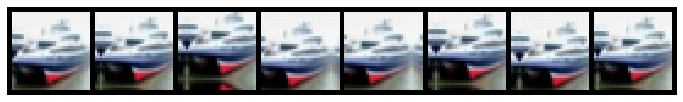

In [18]:
show_batch(trial_dl,rows=8)

In [19]:
trial_data = VisionData().load(tfms=transforms.Compose([transforms.RandomRotation(15),transforms.ToTensor()]),train=False)
trial_data.data=np.repeat(trial_data.data[1][np.newaxis,...],64,axis=0)
trial_data.targets = [trial_data.targets[1]]*64

Files already downloaded and verified


In [20]:
trial_dl = DataLoader(trial_data,batch_size=8,shuffle=False)

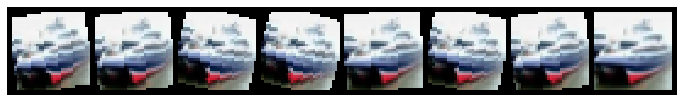

In [21]:
show_batch(trial_dl,rows=8)

In [22]:
trial_data = VisionData().load(tfms=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.ToTensor()]),train=False)
trial_data.data=np.repeat(trial_data.data[1][np.newaxis,...],64,axis=0)
trial_data.targets = [trial_data.targets[1]]*64

Files already downloaded and verified


In [23]:
trial_dl = DataLoader(trial_data,batch_size=8,shuffle=False)

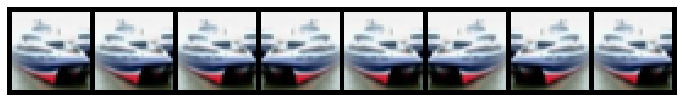

In [24]:
show_batch(trial_dl,rows=8)

### Defining Model 

In [25]:
model = ResNet(drop=True,p=0.05).cuda()


In [26]:
#model

In [27]:
summary(model,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
         ConvLayer-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,928
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
           Dropout-9           [-1, 64, 32, 32]               0
        ConvLayer-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
          Dropout-13           [-1, 64, 32, 32]               0
        ConvLayer-14           [-1, 64,

### Training 

In [28]:
opt = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9)
sched = StepLR(opt,15,gamma=0.3)
dls={}
dls['train']=trn_dl
dls['valid']=tst_dl
loss_func = nn.CrossEntropyLoss()

In [29]:
ldict=train(model,opt,dls,loss_func,40,scheduler=sched)

Training Loss:1.497, Training Acc:40.000: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[0/40]--> Training Loss:1.683, Training Accuracy:37.256, Validation Loss:1.419, Validation Accuracy:48.080


Training Loss:1.054, Training Acc:58.750: 100%|██████████| 391/391 [00:35<00:00, 11.01it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[1/40]--> Training Loss:1.280, Training Accuracy:53.380, Validation Loss:1.197, Validation Accuracy:57.440


Training Loss:1.043, Training Acc:66.250: 100%|██████████| 391/391 [00:35<00:00, 11.00it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[2/40]--> Training Loss:1.082, Training Accuracy:61.094, Validation Loss:1.115, Validation Accuracy:60.080


Training Loss:0.947, Training Acc:60.000: 100%|██████████| 391/391 [00:35<00:00, 10.99it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[3/40]--> Training Loss:0.970, Training Accuracy:65.122, Validation Loss:0.929, Validation Accuracy:66.720


Training Loss:0.836, Training Acc:73.750: 100%|██████████| 391/391 [00:35<00:00, 10.98it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[4/40]--> Training Loss:0.874, Training Accuracy:68.912, Validation Loss:0.951, Validation Accuracy:66.750


Training Loss:0.583, Training Acc:80.000: 100%|██████████| 391/391 [00:35<00:00, 10.94it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[5/40]--> Training Loss:0.804, Training Accuracy:71.502, Validation Loss:0.792, Validation Accuracy:71.520


Training Loss:0.684, Training Acc:75.000: 100%|██████████| 391/391 [00:35<00:00, 10.95it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[6/40]--> Training Loss:0.743, Training Accuracy:73.974, Validation Loss:0.817, Validation Accuracy:71.870


Training Loss:0.774, Training Acc:70.000: 100%|██████████| 391/391 [00:35<00:00, 10.95it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[7/40]--> Training Loss:0.689, Training Accuracy:75.744, Validation Loss:0.701, Validation Accuracy:75.420


Training Loss:0.602, Training Acc:73.750: 100%|██████████| 391/391 [00:35<00:00, 10.92it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[8/40]--> Training Loss:0.648, Training Accuracy:77.260, Validation Loss:0.776, Validation Accuracy:73.160


Training Loss:0.674, Training Acc:73.750: 100%|██████████| 391/391 [00:35<00:00, 10.91it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[9/40]--> Training Loss:0.615, Training Accuracy:78.384, Validation Loss:0.639, Validation Accuracy:77.930


Training Loss:0.600, Training Acc:76.250: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[10/40]--> Training Loss:0.579, Training Accuracy:79.662, Validation Loss:0.639, Validation Accuracy:78.290


Training Loss:0.594, Training Acc:78.750: 100%|██████████| 391/391 [00:35<00:00, 10.92it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[11/40]--> Training Loss:0.557, Training Accuracy:80.508, Validation Loss:0.618, Validation Accuracy:78.640


Training Loss:0.629, Training Acc:73.750: 100%|██████████| 391/391 [00:35<00:00, 10.92it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[12/40]--> Training Loss:0.527, Training Accuracy:81.488, Validation Loss:0.575, Validation Accuracy:80.090


Training Loss:0.387, Training Acc:82.500: 100%|██████████| 391/391 [00:35<00:00, 10.94it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[13/40]--> Training Loss:0.507, Training Accuracy:82.282, Validation Loss:0.571, Validation Accuracy:80.380


Training Loss:0.447, Training Acc:85.000: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[14/40]--> Training Loss:0.484, Training Accuracy:82.874, Validation Loss:0.537, Validation Accuracy:81.630


Training Loss:0.350, Training Acc:86.250: 100%|██████████| 391/391 [00:35<00:00, 10.97it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[15/40]--> Training Loss:0.422, Training Accuracy:85.286, Validation Loss:0.479, Validation Accuracy:83.230


Training Loss:0.350, Training Acc:86.250: 100%|██████████| 391/391 [00:35<00:00, 10.92it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[16/40]--> Training Loss:0.411, Training Accuracy:85.694, Validation Loss:0.476, Validation Accuracy:84.080


Training Loss:0.389, Training Acc:85.000: 100%|██████████| 391/391 [00:35<00:00, 10.91it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[17/40]--> Training Loss:0.401, Training Accuracy:85.962, Validation Loss:0.466, Validation Accuracy:84.150


Training Loss:0.308, Training Acc:88.750: 100%|██████████| 391/391 [00:35<00:00, 10.92it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[18/40]--> Training Loss:0.393, Training Accuracy:86.252, Validation Loss:0.458, Validation Accuracy:84.460


Training Loss:0.511, Training Acc:81.250: 100%|██████████| 391/391 [00:35<00:00, 10.92it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[19/40]--> Training Loss:0.389, Training Accuracy:86.500, Validation Loss:0.449, Validation Accuracy:84.530


Training Loss:0.372, Training Acc:91.250: 100%|██████████| 391/391 [00:35<00:00, 10.94it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[20/40]--> Training Loss:0.382, Training Accuracy:86.584, Validation Loss:0.460, Validation Accuracy:84.560


Training Loss:0.468, Training Acc:87.500: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[21/40]--> Training Loss:0.377, Training Accuracy:86.788, Validation Loss:0.465, Validation Accuracy:84.370


Training Loss:0.388, Training Acc:88.750: 100%|██████████| 391/391 [00:35<00:00, 10.92it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[22/40]--> Training Loss:0.372, Training Accuracy:86.966, Validation Loss:0.437, Validation Accuracy:85.050


Training Loss:0.483, Training Acc:81.250: 100%|██████████| 391/391 [00:35<00:00, 10.91it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[23/40]--> Training Loss:0.364, Training Accuracy:87.376, Validation Loss:0.438, Validation Accuracy:85.610


Training Loss:0.444, Training Acc:81.250: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[24/40]--> Training Loss:0.361, Training Accuracy:87.296, Validation Loss:0.441, Validation Accuracy:85.090


Training Loss:0.382, Training Acc:86.250: 100%|██████████| 391/391 [00:35<00:00, 10.92it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[25/40]--> Training Loss:0.356, Training Accuracy:87.482, Validation Loss:0.437, Validation Accuracy:85.390


Training Loss:0.427, Training Acc:83.750: 100%|██████████| 391/391 [00:35<00:00, 10.91it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[26/40]--> Training Loss:0.348, Training Accuracy:87.790, Validation Loss:0.430, Validation Accuracy:85.790


Training Loss:0.458, Training Acc:87.500: 100%|██████████| 391/391 [00:35<00:00, 10.92it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[27/40]--> Training Loss:0.348, Training Accuracy:87.828, Validation Loss:0.427, Validation Accuracy:85.900


Training Loss:0.406, Training Acc:86.250: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[28/40]--> Training Loss:0.341, Training Accuracy:88.014, Validation Loss:0.423, Validation Accuracy:85.690


Training Loss:0.292, Training Acc:88.750: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[29/40]--> Training Loss:0.336, Training Accuracy:88.310, Validation Loss:0.439, Validation Accuracy:85.260


Training Loss:0.437, Training Acc:88.750: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[30/40]--> Training Loss:0.315, Training Accuracy:89.162, Validation Loss:0.414, Validation Accuracy:86.030


Training Loss:0.407, Training Acc:83.750: 100%|██████████| 391/391 [00:35<00:00, 10.91it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[31/40]--> Training Loss:0.312, Training Accuracy:89.100, Validation Loss:0.410, Validation Accuracy:86.330


Training Loss:0.235, Training Acc:91.250: 100%|██████████| 391/391 [00:35<00:00, 10.91it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[32/40]--> Training Loss:0.308, Training Accuracy:89.272, Validation Loss:0.415, Validation Accuracy:85.920


Training Loss:0.349, Training Acc:87.500: 100%|██████████| 391/391 [00:35<00:00, 10.89it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[33/40]--> Training Loss:0.305, Training Accuracy:89.370, Validation Loss:0.407, Validation Accuracy:86.180


Training Loss:0.350, Training Acc:86.250: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[34/40]--> Training Loss:0.305, Training Accuracy:89.286, Validation Loss:0.413, Validation Accuracy:86.130


Training Loss:0.320, Training Acc:91.250: 100%|██████████| 391/391 [00:35<00:00, 10.94it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[35/40]--> Training Loss:0.307, Training Accuracy:89.184, Validation Loss:0.399, Validation Accuracy:86.600


Training Loss:0.396, Training Acc:88.750: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[36/40]--> Training Loss:0.295, Training Accuracy:89.560, Validation Loss:0.404, Validation Accuracy:86.630


Training Loss:0.316, Training Acc:91.250: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[37/40]--> Training Loss:0.301, Training Accuracy:89.538, Validation Loss:0.404, Validation Accuracy:86.640


Training Loss:0.211, Training Acc:92.500: 100%|██████████| 391/391 [00:35<00:00, 10.88it/s]


  0%|          | 0/391 [00:00<?, ?it/s]


[38/40]--> Training Loss:0.298, Training Accuracy:89.452, Validation Loss:0.396, Validation Accuracy:86.820


Training Loss:0.338, Training Acc:87.500: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s]



[39/40]--> Training Loss:0.297, Training Accuracy:89.640, Validation Loss:0.405, Validation Accuracy:86.620


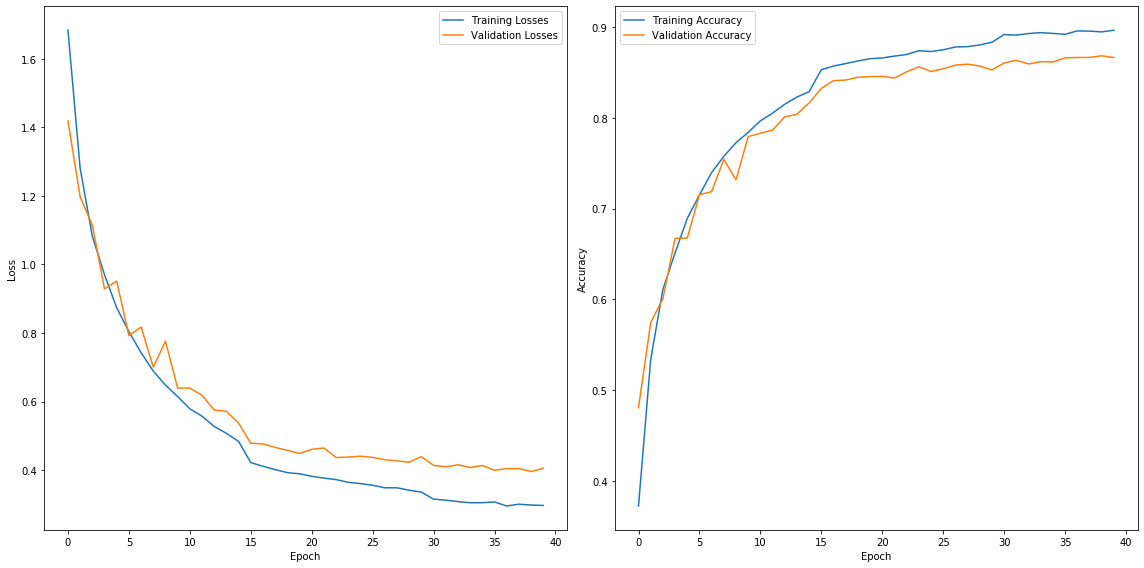

In [30]:
plot_diagnostics(ldict)

In [34]:
test_res=test(model,tst_dl,loss_func,device='cuda')

In [39]:
print(f"Final Test Loss: {test_res['Loss']}")
print(f"Final Test Accuracy: {test_res['Accuracy']}")

Final Test Loss: 0.400401958322525
Final Test Accuracy: 86.78
